In [1]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
from root_dataset import Train_dataset, Test_dataset
import albumentations as albu
import pytorch_ssim
import pytorch_iou
import model
import random
import numpy as np
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
height = 512

In [4]:
def get_train_augmentation(height):
    trainaugmentation = albu.Compose([
        albu.Resize(height,height),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomRotate90(p=0.5),
        albu.Transpose(p=0.5),
        albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.5),
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        albu.GridDistortion(p=0.5),
        albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        albu.RandomBrightnessContrast(p=0.5),
        albu.RandomGamma(p=0.5),
        albu.GaussianBlur(blur_limit=(3, 7), p=0.5),
        albu.GaussNoise(),
        albu.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5), 
        #albu.Lambda(image=lambda x,**kwargs: x/255),
    ])
    return trainaugmentation

In [5]:
def get_val_augmentation(height):
    trainaugmentation = albu.Compose([
        albu.Resize(height,height),
        # albu.Lambda(image=lambda x,**kwargs: x/255),
    ])
    return trainaugmentation

In [6]:
train_aug = get_train_augmentation(height)
val_aug = get_val_augmentation(height)

In [7]:
train = Train_dataset(height,train_aug,'crosval/train','castom-masks/masks_machine',device)
val = Train_dataset(height,val_aug,'crosval/val','castom-masks/masks_machine',device)

['AAE_0014.png', 'AAE_0016.png', 'AAE_0017.png', 'AAE_0019.png', 'AAE_0021.png', 'AAE_0022.png', 'AAE_0025.png', 'AAE_0027.png', 'AAE_0028.png', 'AAE_0036.png', 'AAE_0037.png', 'AAE_0040.png', 'AAE_0041.png', 'AAE_0045.png', 'AAE_0047.png', 'AAE_0048.png', 'AAE_0057.png', 'AAE_0058.png', 'AAE_0062.png', 'AAE_0063.png', 'AAE_0068.png', 'AAE_0070.png', 'AAE_0071.png', 'AAE_0073.png', 'AAE_0076.png', 'AAE_0080.png', 'AAE_0083.png', 'AAE_0085.png', 'AAE_0087.png', 'AAE_0089.png', 'AAE_0097.png', 'AAE_0098.png', 'AAE_0100.png', 'AAE_0101.png', 'AAE_0107.png', 'AAE_0114.png', 'AAE_0116.png', 'AAE_0117.png', 'AAE_0119.png', 'AAE_0124.png', 'AAE_0125.png', 'AAE_0127.png', 'AAE_0136.png', 'AAE_0140.png', 'AAE_0144.png', 'AAE_0145.png', 'AAE_0146.png', 'AAE_0147.png', 'AAE_0150.png', 'AAE_0154.png', 'AAE_0156.png', 'AAE_0158.png', 'AAE_0161.png', 'AAE_0165.png', 'AAE_0167.png', 'AAE_0170.png', 'AAE_0173.png', 'AAE_0174.png', 'AAE_0176.png', 'AAE_0177.png', 'AAE_0179.png', 'AAE_0180.png', 'AAE_01

<Figure size 640x480 with 0 Axes>

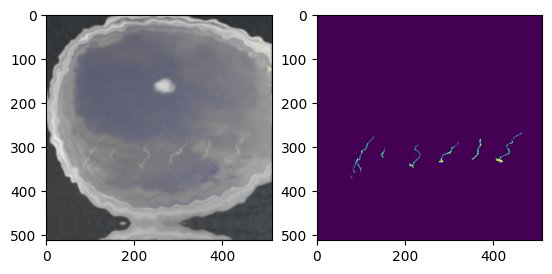

In [8]:
plt.figure()
f, axarr = plt.subplots(1,2) 
image,mask = train.__getitem__(0)
axarr[0].imshow(image.permute(1,2,0).cpu())
axarr[1].imshow(mask.permute(1,2,0).cpu())

In [9]:
model = model.UNet(3,1)

In [10]:
train_loader = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=False)

In [11]:
bce_loss = torch.nn.BCELoss(size_average=True)
ssim_loss = pytorch_ssim.SSIM(window_size=11,size_average=True)
iou_loss = pytorch_iou.IOU(size_average=True)
optimizer = torch.optim.Adam(model.parameters(),0.001,amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=5,verbose=True)

c:\Users\neden\miniconda3\envs\torch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [12]:
def bce_ssim_loss(pred,target):

	bce_out = bce_loss(pred,target)
	ssim_out = 1 - ssim_loss(pred,target)
	iou_out = iou_loss(pred,target)

	loss = bce_out + ssim_out + iou_out

	return loss

In [13]:
epochs = 200
patience = 20
model_path = 'models/new_loss_model.pt'

In [14]:
model.to(device)
best_loss = 100
counter = 0
for epoch in range(epochs):
    train_loss = 0.0
    model.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = bce_ssim_loss(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    val_loss = 0.0

    model.eval()
    for inputs, targets in tqdm(val_loader):
        model.eval()
        outputs = model(inputs)
            
            # Calculate loss
        loss = bce_ssim_loss(outputs, targets)
        val_loss += loss.item()

    val_loss /= len(val_loader)

    scheduler.step(val_loss)

    improve = False

    if val_loss < best_loss: 
        best_loss = val_loss
        improve = True
        print('model saved')
        torch.save(model,model_path)

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    if not improve:
        counter += 1
        if counter > patience:
            print('early stop')
            break
    else:
        counter = 0
        

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [1/200] | Train Loss: 2.6318 | Val Loss: 2.6341


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


model saved
Epoch [2/200] | Train Loss: 2.4479 | Val Loss: 2.5208


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [3/200] | Train Loss: 2.3680 | Val Loss: 2.4359


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [4/200] | Train Loss: 2.3052 | Val Loss: 2.3615


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


model saved
Epoch [5/200] | Train Loss: 2.2623 | Val Loss: 2.3077


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [6/200] | Train Loss: 2.2395 | Val Loss: 2.2658


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


model saved
Epoch [7/200] | Train Loss: 2.1978 | Val Loss: 2.2131


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


model saved
Epoch [8/200] | Train Loss: 2.1787 | Val Loss: 2.1807


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


model saved
Epoch [9/200] | Train Loss: 2.1671 | Val Loss: 2.1621


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


model saved
Epoch [10/200] | Train Loss: 2.1372 | Val Loss: 2.1218


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [11/200] | Train Loss: 2.1235 | Val Loss: 2.1042


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


model saved
Epoch [12/200] | Train Loss: 2.1111 | Val Loss: 2.0801


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


model saved
Epoch [13/200] | Train Loss: 2.1000 | Val Loss: 2.0475


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [14/200] | Train Loss: 2.0754 | Val Loss: 2.0425


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [15/200] | Train Loss: 2.0522 | Val Loss: 2.0522


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


model saved
Epoch [16/200] | Train Loss: 2.0231 | Val Loss: 2.0250


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Epoch [17/200] | Train Loss: 1.9715 | Val Loss: 2.1177


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Epoch [18/200] | Train Loss: 1.9161 | Val Loss: 2.2315


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


Epoch [19/200] | Train Loss: 1.8408 | Val Loss: 2.2617


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


Epoch [20/200] | Train Loss: 1.7442 | Val Loss: 2.0875


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


model saved
Epoch [21/200] | Train Loss: 1.6569 | Val Loss: 1.8728


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Epoch [22/200] | Train Loss: 1.5646 | Val Loss: 1.8997


100%|██████████| 7/7 [00:06<00:00,  1.10it/s]


model saved
Epoch [23/200] | Train Loss: 1.5055 | Val Loss: 1.6484


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


model saved
Epoch [24/200] | Train Loss: 1.4482 | Val Loss: 1.3402


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


model saved
Epoch [25/200] | Train Loss: 1.4042 | Val Loss: 1.2215


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [26/200] | Train Loss: 1.3554 | Val Loss: 1.8608


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Epoch [27/200] | Train Loss: 1.3562 | Val Loss: 1.5067


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


Epoch [28/200] | Train Loss: 1.3064 | Val Loss: 1.4006


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Epoch [29/200] | Train Loss: 1.2770 | Val Loss: 1.2732


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


model saved
Epoch [30/200] | Train Loss: 1.2313 | Val Loss: 1.1573


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


model saved
Epoch [31/200] | Train Loss: 1.1841 | Val Loss: 1.1042


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [32/200] | Train Loss: 1.1175 | Val Loss: 0.9915


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [33/200] | Train Loss: 1.0935 | Val Loss: 1.2288


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [34/200] | Train Loss: 1.0249 | Val Loss: 1.0388


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


Epoch [35/200] | Train Loss: 1.0258 | Val Loss: 1.0361


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


model saved
Epoch [36/200] | Train Loss: 0.9352 | Val Loss: 0.8634


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


model saved
Epoch [37/200] | Train Loss: 0.9020 | Val Loss: 0.8128


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


model saved
Epoch [38/200] | Train Loss: 0.8724 | Val Loss: 0.7847


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Epoch [39/200] | Train Loss: 0.8897 | Val Loss: 0.8787


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


model saved
Epoch [40/200] | Train Loss: 0.8793 | Val Loss: 0.7169


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [41/200] | Train Loss: 0.8378 | Val Loss: 0.7067


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


Epoch [42/200] | Train Loss: 0.8088 | Val Loss: 0.8509


100%|██████████| 7/7 [00:06<00:00,  1.10it/s]


model saved
Epoch [43/200] | Train Loss: 0.8214 | Val Loss: 0.6692


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Epoch [44/200] | Train Loss: 0.8072 | Val Loss: 0.6738


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [45/200] | Train Loss: 0.8047 | Val Loss: 0.6766


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


Epoch [46/200] | Train Loss: 0.8212 | Val Loss: 0.7926


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Epoch [47/200] | Train Loss: 0.8326 | Val Loss: 0.7332


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


model saved
Epoch [48/200] | Train Loss: 0.7883 | Val Loss: 0.6647


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [49/200] | Train Loss: 0.7482 | Val Loss: 0.6114


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Epoch [50/200] | Train Loss: 0.7512 | Val Loss: 0.6171


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Epoch [51/200] | Train Loss: 0.7483 | Val Loss: 0.6392


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [52/200] | Train Loss: 0.7477 | Val Loss: 0.6626


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Epoch [53/200] | Train Loss: 0.7518 | Val Loss: 0.6137


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [54/200] | Train Loss: 0.7263 | Val Loss: 0.5829


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


model saved
Epoch [55/200] | Train Loss: 0.7243 | Val Loss: 0.5793


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Epoch [56/200] | Train Loss: 0.7350 | Val Loss: 0.6452


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


Epoch [57/200] | Train Loss: 0.7444 | Val Loss: 0.5922


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [58/200] | Train Loss: 0.7180 | Val Loss: 0.5651


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [59/200] | Train Loss: 0.6999 | Val Loss: 0.5778


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Epoch [60/200] | Train Loss: 0.7274 | Val Loss: 0.6085


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [61/200] | Train Loss: 0.7172 | Val Loss: 0.5933


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [62/200] | Train Loss: 0.7054 | Val Loss: 0.6089


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Epoch [63/200] | Train Loss: 0.7182 | Val Loss: 0.5819


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch 00064: reducing learning rate of group 0 to 1.0000e-04.
Epoch [64/200] | Train Loss: 0.6928 | Val Loss: 0.6549


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [65/200] | Train Loss: 0.7148 | Val Loss: 0.6042


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Epoch [66/200] | Train Loss: 0.6980 | Val Loss: 0.5705


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


model saved
Epoch [67/200] | Train Loss: 0.7055 | Val Loss: 0.5622


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [68/200] | Train Loss: 0.6790 | Val Loss: 0.5589


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [69/200] | Train Loss: 0.6975 | Val Loss: 0.5595


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


Epoch [70/200] | Train Loss: 0.6841 | Val Loss: 0.5639


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [71/200] | Train Loss: 0.6604 | Val Loss: 0.5650


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Epoch [72/200] | Train Loss: 0.6693 | Val Loss: 0.5711


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


Epoch [73/200] | Train Loss: 0.6804 | Val Loss: 0.5730


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


model saved
Epoch [74/200] | Train Loss: 0.6698 | Val Loss: 0.5550


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


model saved
Epoch [75/200] | Train Loss: 0.6739 | Val Loss: 0.5503


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [76/200] | Train Loss: 0.6715 | Val Loss: 0.5507


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


model saved
Epoch [77/200] | Train Loss: 0.6575 | Val Loss: 0.5495


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Epoch [78/200] | Train Loss: 0.6635 | Val Loss: 0.5503


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [79/200] | Train Loss: 0.6716 | Val Loss: 0.5506


100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


Epoch [80/200] | Train Loss: 0.6769 | Val Loss: 0.5530


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Epoch [81/200] | Train Loss: 0.6905 | Val Loss: 0.5547


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Epoch [82/200] | Train Loss: 0.6611 | Val Loss: 0.5582


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Epoch 00083: reducing learning rate of group 0 to 1.0000e-05.
Epoch [83/200] | Train Loss: 0.6580 | Val Loss: 0.5506


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


model saved
Epoch [84/200] | Train Loss: 0.6735 | Val Loss: 0.5494


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


model saved
Epoch [85/200] | Train Loss: 0.6650 | Val Loss: 0.5479


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Epoch [86/200] | Train Loss: 0.6682 | Val Loss: 0.5511


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Epoch [87/200] | Train Loss: 0.6702 | Val Loss: 0.5511


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Epoch [88/200] | Train Loss: 0.6567 | Val Loss: 0.5502


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Epoch [89/200] | Train Loss: 0.6672 | Val Loss: 0.5483


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Epoch [90/200] | Train Loss: 0.6590 | Val Loss: 0.5509


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch 00091: reducing learning rate of group 0 to 1.0000e-06.
Epoch [91/200] | Train Loss: 0.6622 | Val Loss: 0.5512


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Epoch [92/200] | Train Loss: 0.6627 | Val Loss: 0.5524


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Epoch [93/200] | Train Loss: 0.6736 | Val Loss: 0.5507


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [94/200] | Train Loss: 0.6682 | Val Loss: 0.5460


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Epoch [95/200] | Train Loss: 0.6783 | Val Loss: 0.5494


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Epoch [96/200] | Train Loss: 0.6571 | Val Loss: 0.5496


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Epoch [97/200] | Train Loss: 0.6603 | Val Loss: 0.5493


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Epoch [98/200] | Train Loss: 0.6722 | Val Loss: 0.5490


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Epoch [99/200] | Train Loss: 0.6811 | Val Loss: 0.5502


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Epoch 00100: reducing learning rate of group 0 to 1.0000e-07.
Epoch [100/200] | Train Loss: 0.6606 | Val Loss: 0.5477


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Epoch [101/200] | Train Loss: 0.6619 | Val Loss: 0.5504


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Epoch [102/200] | Train Loss: 0.6720 | Val Loss: 0.5496


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


Epoch [103/200] | Train Loss: 0.6768 | Val Loss: 0.5488


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Epoch [104/200] | Train Loss: 0.6718 | Val Loss: 0.5487


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Epoch [105/200] | Train Loss: 0.6703 | Val Loss: 0.5522


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Epoch 00106: reducing learning rate of group 0 to 1.0000e-08.
Epoch [106/200] | Train Loss: 0.6741 | Val Loss: 0.5487


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Epoch [107/200] | Train Loss: 0.6601 | Val Loss: 0.5485


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Epoch [108/200] | Train Loss: 0.6715 | Val Loss: 0.5503


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [109/200] | Train Loss: 0.6613 | Val Loss: 0.5508


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Epoch [110/200] | Train Loss: 0.6854 | Val Loss: 0.5485


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Epoch [111/200] | Train Loss: 0.6516 | Val Loss: 0.5529


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Epoch [112/200] | Train Loss: 0.6792 | Val Loss: 0.5525


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


Epoch [113/200] | Train Loss: 0.6686 | Val Loss: 0.5519


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Epoch [114/200] | Train Loss: 0.6742 | Val Loss: 0.5502


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

Epoch [115/200] | Train Loss: 0.6728 | Val Loss: 0.5513
early stop


Epoch [61/100] | Train Loss: 0.8235 | Val Loss: 0.8208

In [15]:
model = torch.load(model_path)

Epoch [10/10] | Train Loss: 4.1113 | Val Loss: 3.9804

In [16]:
test = Test_dataset(val_aug,'crosval/test',device)

['AAE_0023.png', 'AAE_0074.png', 'AAE_0086.png', 'AAE_0138.png', 'AAE_0160.png', 'AAE_0172.png', 'AAE_0205.png', 'AAE_0221.png', 'AAE_0223.png', 'AAE_0237.png']


In [17]:
test_loader = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

In [18]:
for inputs in tqdm(test_loader):
    model.eval()
    outputs = model(inputs)

100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


In [19]:
outputs.shape

torch.Size([10, 1, 512, 512])

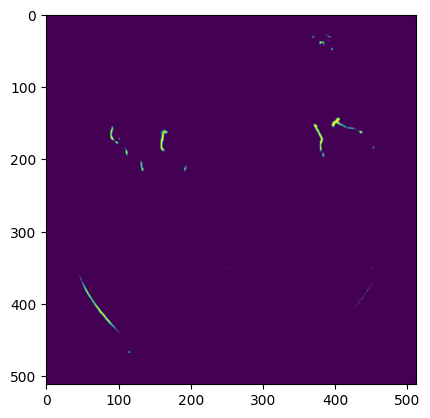

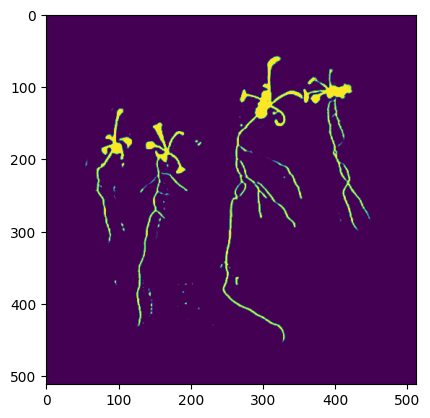

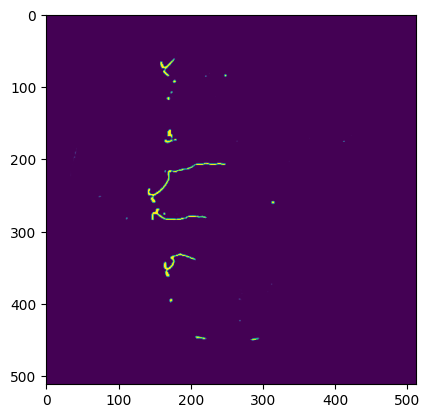

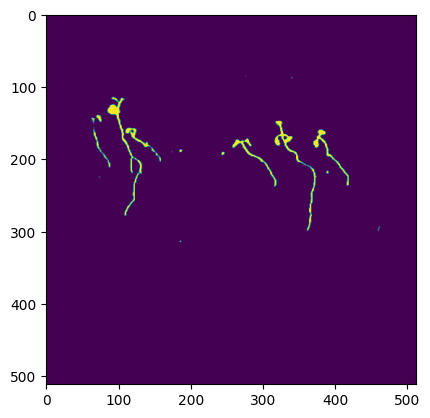

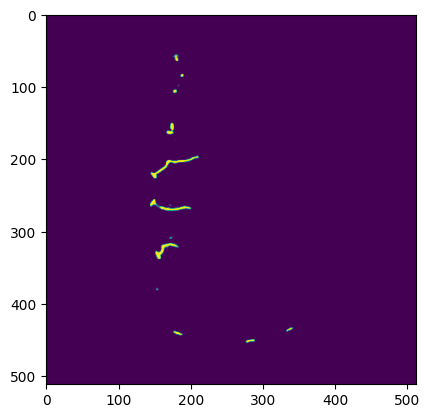

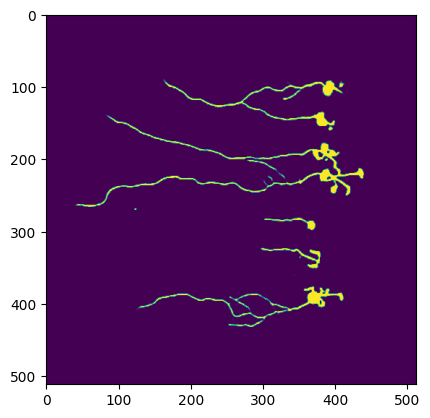

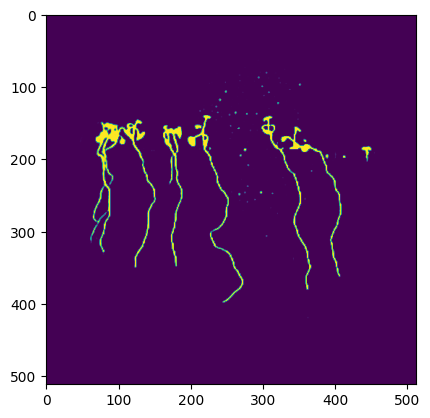

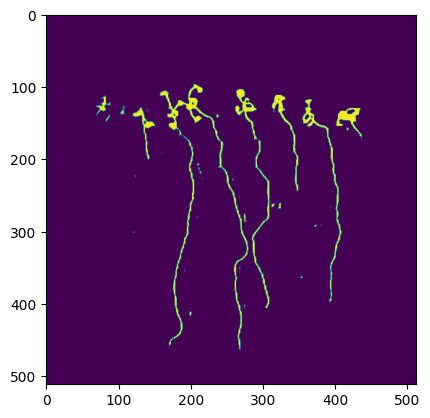

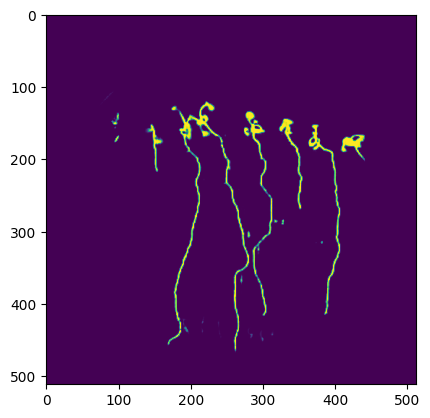

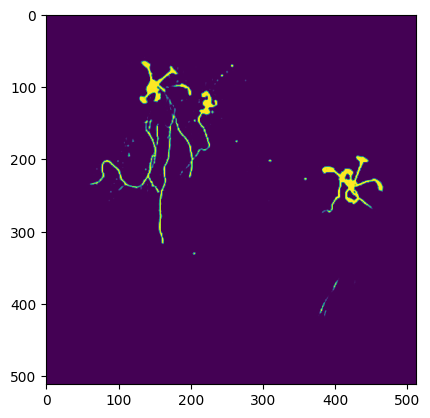

In [20]:
for i in outputs:
    i.reshape(1, height, height)
    plt.imshow(i.cpu().permute(1,2,0).detach().numpy())
    plt.pause(1)